In [25]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 16,
    "font.size": 16,
    "axes.titlesize" : 16,
    'text.latex.preamble': r'\usepackage{amsfonts, amsmath,amssymb, mathrsfs}',
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14, 
    'figure.autolayout': True
    
}

import matplotlib.pyplot as plt 
import matplotlib
plt.rcParams.update(tex_fonts)


matplotlib.rc('lines', linewidth=2, markersize=3)

def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 500.02908
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import convolve
import pandas as pd
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [27]:
#### WESTERN EUROPE ####
df_list = []
df = pd.read_csv('Data FAO/FAOSTAT_AREA.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_YIELD.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_FERTILIZER.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_PESTICIDE.csv')
df_list.append(df)
df_Price = pd.read_csv('Data FAO/commodity-price-index-cereal-crops-and-petroleum.csv')
df_Price = df_Price.rename(columns={"Wheat": "Value"})
condition = df_Price['Year'] >= 1961
df_Price = df_Price[condition]
df_list.append(df_Price)

In [280]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import convolve
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.signal import convolve2d
import random

np.random.seed(42)

class Landscape:
    def __init__(self, size = 20, frac_conventional = 0.3, frac_organic = 0., frac_natural = 0.7, mean_initial_fertilizer = 40, std_initial_fertilizer = 10, mean_initial_pesticides = 3, std_initial_pesticides = 0.5, \
                    mean_soil_health_agri = 1, std_soil_health_agri = 0,\
                        y_max = 8, Nutrient_uptake_efficiency = 1, Nutrient_release_SOM = 30, N_req = 70, \
                            Maximum_Pest_impact = 0.2, biodiversity_vs_pesticides_protection = 0.3, Pesticides_required = 5, \
                                SOM_rate_conventional = -.02, SOM_rate_organic = 0., SOM_rate_natural = 0.05, biodiversity_organic = 0.0, omega = 0, \
                                    Fertilizer_price = 1, Pesticide_price = 30, fixed_cost_conventional = 500, initial_wealth = 100000, Fertilizer_choice_profit_impact = 0.2, Fertilizer_choice_other_farmer = 0.1, threshold_base = 0.1, \
                                        subsidy_strength_production = 0, subsidy_strength_organic = 0, policy_strength_natural= 0, market_demand_increase = 0.02, market_price_sensitivity = 0.15, initial_markup = 1,
                                            fraction_for_land = 0.01, initial_MP = 1, investment_fraction = 0.001, effectiveness_innovation_expenditure = 500, mean_innovation_advancement = 0.008
                                            ):
            
        self.size = size

        # Environmental Parameters
        self.y_max = y_max # Maximum Yield [ton/ha]
        self.Nutrient_uptake_efficiency = Nutrient_uptake_efficiency # Nutrient uptake efficiency 
        self.Nutrient_release_SOM = Nutrient_release_SOM # Nutrient release from SOM decomposition [Kg/ha]
        self.N_req = N_req # Nutrient requirement for growth [ton/ha]
        self.Maximum_Pest_impact = Maximum_Pest_impact # Maximum pest impact 
        self.biodiversity_vs_pesticides_protection = biodiversity_vs_pesticides_protection # Protection potential of biodiversity vs pesticides
        self.Pesticides_required = Pesticides_required # Required Pesticides [kg]
        self.SOM_rate_conventional = SOM_rate_conventional # SOM decomposition rate under conventional farming
        self.SOM_rate_organic = SOM_rate_organic # SOM regeneration rate under organic farming
        self.SOM_rate_natural = SOM_rate_natural # SOM regeneration rate under natural 
        self.biodiversity_organic = biodiversity_organic # Biodiversity contribution from organic
        self.omega = omega

        # Economic Parameters
        self.Fertilizer_price = Fertilizer_price # Cost per kilogram of fertilizer
        self.Pesticide_price = Pesticide_price # Cost per kilogram of pesticide
        self.fixed_cost_conventional = fixed_cost_conventional # Fixed cost for conventional production
        self.Fertilizer_choice_profit_impact = Fertilizer_choice_profit_impact
        self.Fertilizer_choice_other_farmer = Fertilizer_choice_other_farmer
        self.threshold_base = threshold_base # Production switch threshold 
        self.market_demand_increase = market_demand_increase
        self.market_price_sensitivity = market_price_sensitivity
        self.initial_markup = initial_markup
        self.fraction_for_land = fraction_for_land
        self.investment_fraction = investment_fraction
        self.effectiveness_innovation_expenditure = effectiveness_innovation_expenditure
        self.mean_innovation_advancement = mean_innovation_advancement

        # Policy Parameters
        self.subsidy_strength_production = subsidy_strength_production
        self.subsidy_strength_organic = subsidy_strength_organic
        self.policy_strength_natural = policy_strength_natural


        # Initialize matrices
        if frac_conventional + frac_natural + frac_organic != 1:
            raise AttributeError("Input the right amount of initial fractions")
        
        self.initialize_land_types(frac_conventional, frac_organic, frac_natural)
        self.soil_health, self.biodiversity = self.initialize_soil_health_and_biodiversity(mean_soil_health_agri, std_soil_health_agri)
        self.farms_ownership = np.zeros(self.land_type.shape) 
        self.farms_ownership[self.land_type != 'N'] = np.arange(1, np.sum(self.land_type != 'N') + 1)
        self.max_idx_farms_ownership = self.farms_ownership.max()
        
        # Calculate initial productivity
        self.ManagementPractices = initial_MP * np.ones((self.size, self.size))
        self.pesticides = (self.land_type == 'C') * np.clip(np.random.normal(mean_initial_pesticides, std_initial_pesticides, (size, size)), 1e-3, np.inf)
        self.fertilizer = (self.land_type == 'C') * np.clip(np.random.normal(mean_initial_fertilizer, std_initial_fertilizer, (size, size)), 1e-3, np.inf)
        self.productivity = self.productionfunction(self.fertilizer, self.pesticides)
        self.initial_productivity = np.sum(self.productivity)
        self.market_demand = self.initial_productivity
        self.cost = (self.land_type == 'C') *  (self.Fertilizer_price * self.fertilizer + self.Pesticide_price * self.pesticides + np.where(self.land_type == 'C', self.fixed_cost_conventional, 0))
        self.prices = self.cost / np.where(self.productivity>0, self.productivity, 1)
        self.market_price = self.prices[self.prices > 0].max() #self.initial_markup * np.mean(self.prices[self.prices > 0])
        self.profits = (self.market_price - self.prices) * self.productivity
        self.wealth = initial_wealth * np.ones((self.size, self.size))

        # Initialize data for plotting
        self.data = {'total_productivity': [], 'demand': [], 'O': [], 'C': [], 'N':[], 'market_price': [], 'total_economic_value': [], 'land_type_changes': [], \
                     'mean_Y': [], 'std_Y': [], 'mean_F':[], 'std_F':[], 'mean_P': [], 'std_P':[], 'mean_Soil':[], 'std_Soil':[], 'mean_BIO':[], 'std_BIO':[], 'mean_Profit':[], 'std_Profit':[], \
                         'mean_Price':[], 'std_Price':[], 'mean_wealth':[], 'std_wealth':[], 'mean_MP':[], 'std_MP':[] }

    def initialize_land_types(self, frac_conventional, frac_organic, frac_natural):
        total_cells = self.size * self.size
        num_conventional = int(total_cells * frac_conventional)
        num_organic = int(total_cells * frac_organic)
        num_natural = total_cells - num_conventional - num_organic

        land_types_flat = (['C'] * num_conventional +
                           ['O'] * num_organic +
                           ['N'] * num_natural)

        np.random.shuffle(land_types_flat)
        self.land_type = np.array(land_types_flat).reshape((self.size, self.size))

    def initialize_soil_health_and_biodiversity(self, mean, std):
        soil_health = np.zeros((self.size, self.size))
        soil_health[self.land_type != 'N'] = np.random.normal(mean, std, (self.size, self.size))[self.land_type != 'N']
        soil_health[self.land_type == 'N'] = 1
        soil_health = np.clip(soil_health, 0, 1)
        
        biodiversity = np.zeros((self.size, self.size))
        biodiversity[self.land_type == 'N'] = 1
        biodiversity[self.land_type != 'N'] = 0.6

        return soil_health, biodiversity
    
    def update_soil_health(self):
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve(self.soil_health, kernel, mode='wrap')

        delta_h = np.where(self.land_type == 'O', self.SOM_rate_organic, self.SOM_rate_conventional)
        delta_h[self.land_type == 'N'] = self.SOM_rate_natural
        self.soil_health += (delta_h + self.omega * avg_neighbors) * self.soil_health
        # self.land_type[self.soil_health < 0] = 'N'
        # self.wealth[self.soil_health < 0] = 0
        self.soil_health = np.clip(self.soil_health, 0, 1)

    def update_biodiversity(self):

        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve(self.biodiversity, kernel, mode='wrap')
        delta_b = np.where(self.land_type == 'O', 0.01, -0.05)
        delta_b[self.land_type == 'N'] = 0.05
        self.biodiversity += (delta_b + self.omega * avg_neighbors) * self.biodiversity
        self.biodiversity = np.clip(self.biodiversity, 0, 1)
    
    def productionfunction(self, fertilizer, pesticide):

        production =  self.y_max * (1 - np.exp(-1/self.N_req * ( self.ManagementPractices * fertilizer + self.Nutrient_release_SOM * self.soil_health))) \
                        * (1 - self.Maximum_Pest_impact * np.exp( - self.biodiversity_vs_pesticides_protection * self.biodiversity - (1 - self.biodiversity_vs_pesticides_protection) * pesticide / self.Pesticides_required)) \
                            * (1 + np.random.normal(0, 0.1, (self.size, self.size)))\
                                * (self.land_type != "N")
        return production
    
    def planning_phase(self):
        expected_market_price = self.market_price
        
        Fertilizer_change = np.linspace(0.5,1.5,20)
        Pest_change = np.linspace(0.5,1.5,20)
        mesh = np.array(np.meshgrid(Fertilizer_change, Pest_change)).T.reshape(-1,2)

        F_try = self.fertilizer * mesh[:,0][:, np.newaxis, np.newaxis]
        P_try = self.pesticides * mesh[:,1][:, np.newaxis, np.newaxis]

        Profit_try = (expected_market_price + self.subsidy_strength_production) * self.productionfunction(F_try, P_try) - self.Fertilizer_price * F_try - self.Pesticide_price * P_try - self.fixed_cost_conventional
        F_opt = F_try[np.argmax(Profit_try, axis=0), np.arange(F_try.shape[1])[:, np.newaxis], np.arange(F_try.shape[2])]
        P_opt = P_try[np.argmax(Profit_try, axis=0), np.arange(F_try.shape[1])[:, np.newaxis], np.arange(F_try.shape[2])]
        # F_opt = self.ManagementPractices**-1 * ( - self.N_req * np.log(self.N_req * self.Fertilizer_price / self.market_price / self.y_max) - self.Nutrient_release_SOM * self.soil_health )
        
        # kernel = np.array([[1, 1, 1],
        #                    [1, 0, 1],
        #                    [1, 1, 1]]) / 8.0
        # avg_fertilizer_neighbors = convolve(self.fertilizer * (self.land_type == 'C'), kernel, mode='wrap')
        # print(F_opt[self.land_type == 'C'])
        
        fertilizer = (1 - self.Fertilizer_choice_profit_impact - self.Fertilizer_choice_other_farmer) * self.fertilizer + self.Fertilizer_choice_profit_impact * F_opt + self.Fertilizer_choice_other_farmer * np.mean(self.fertilizer[self.land_type == 'C'])
        pesticide = (1 - self.Fertilizer_choice_profit_impact - self.Fertilizer_choice_other_farmer) * self.pesticides + self.Fertilizer_choice_profit_impact * P_opt + self.Fertilizer_choice_other_farmer * np.mean(self.pesticides[self.land_type == 'C'])
        
        maximum_cost = np.minimum(1, self.wealth / (self.Fertilizer_price * fertilizer + self.Pesticide_price * self.pesticides + 1))

        return maximum_cost * fertilizer * (self.land_type != 'N'), maximum_cost * pesticide * (self.land_type != 'N')

    def computeprices(self):
        cost = (self.land_type == 'C') * (self.Fertilizer_price * self.fertilizer + self.Pesticide_price * self.pesticides + np.where(self.land_type == 'C', self.fixed_cost_conventional, 0))
        prices = self.cost / self.productivity
        return cost, prices

    def compute_sellingmatrix_price(self):
        # Flatten and sort the production values along with their indices
        flattened_productivity = self.productivity.ravel()
        sorted_indices = np.argsort(flattened_productivity)[::-1]
        sorted_productivity = flattened_productivity[sorted_indices]

        # Calculate sold fractions
        cumulative_production = np.cumsum(sorted_productivity)
        sold_fraction = np.zeros_like(sorted_productivity)

        # Find the index where demand is just met or exceeded
        meet_demand_index = np.argmax(cumulative_production >= self.market_demand)

        # If demand is less than or equal to total production
        if cumulative_production[meet_demand_index] >= self.market_demand:
            # Units fully sold
            sold_fraction[:meet_demand_index] = 1
            # The last unit might be partially sold
            if cumulative_production[meet_demand_index] > self.market_demand:
                sold_fraction[meet_demand_index] = (self.market_demand - cumulative_production[meet_demand_index - 1]) / sorted_productivity[meet_demand_index]
        else:
            # All units are sold
            sold_fraction[:] = 1

        # Calculate market price
        last_accepted_production = sorted_productivity[meet_demand_index]
        market_price = self.prices.ravel()[sorted_indices][meet_demand_index] / last_accepted_production 

        # Reconstruct the matrix with the sold fractions in their original positions
        reconstructed_matrix = np.zeros_like(sold_fraction)
        reconstructed_matrix[sorted_indices] = sold_fraction
        return reconstructed_matrix.reshape(self.productivity.shape), market_price
    
    def computeprofit(self):
        selling_matrix, p_M = self.compute_sellingmatrix_price()
        # selling_matrix = np.ones((self.size, self.size))
        
        profit = (self.land_type != 'N') * (selling_matrix * self.productivity * (self.market_price + self.subsidy_strength_production) \
                                                - self.cost 
                                                    + np.where(self.land_type == 'O', self.subsidy_strength_organic, 0))

        return profit
    
    def update_productivity_and_economic_value(self):
        self.fertilizer, self.pesticides = self.planning_phase()
        self.productivity = self.productionfunction(self.fertilizer, self.pesticides)        
        self.cost, self.prices = self.computeprices()
        self.profits = self.computeprofit()
        # self.update_wealth()
        self.wealth += self.profits
        # self.bankrupt = self.wealth < -1
        # self.land_type[self.bankrupt] = 'N'
        # self.wealth[self.bankrupt] = 0

    def investment_decision(self):

        investment_fraction = 0.01
        effectiveness_innovation_expenditure = 50
        mean_innovation_advancement = 0.0
        std_innovation_advancement = 0.05

        invested_wealth = (investment_fraction * self.wealth) * (self.wealth > 0)
        self.wealth -= invested_wealth
        
        farms_innovating = np.random.rand(self.size, self.size) < 1 - np.exp(- 1/effectiveness_innovation_expenditure * invested_wealth) 

        innovation = abs(np.random.normal(mean_innovation_advancement, std_innovation_advancement, (self.size, self.size)))

        self.ManagementPractices[farms_innovating] += innovation[farms_innovating]

    def update_demand(self):
        self.market_demand += self.market_demand_increase * self.initial_productivity 
    
    def update_market_price(self):
        self.market_price = self.market_price * (1 + self.market_price_sensitivity * (self.market_demand - np.sum(self.productivity[self.land_type == 'C'])) / np.sum(self.productivity[self.land_type == 'C']))    

    ### FARMS ###

    def collect_farms_wealth(self):
        
        self.farms_unique, self.farms_counts = np.unique(self.farms_ownership, return_counts=True)
        self.farms_unique = self.farms_unique[1:]
        self.farms_counts = self.farms_counts[1:]
        self.num_unique_values = len(self.farms_unique)  # Number of unique values in A
        masks = (self.farms_ownership[:, :, np.newaxis] == self.farms_unique)
        self.ownership = np.zeros((self.size, self.size,  self.num_unique_values), dtype=int)
        self.ownership[masks] = 1
        self.wealth_per_farmer = np.tensordot(self.wealth, self.ownership)
        self.cost_per_farmer = np.tensordot(self.cost, self.ownership)

    def bankruptcy(self):
        
        self.n_bankrupt = 0
        if np.any(self.wealth_per_farmer < 0):
            bankruptcy = np.argwhere(self.wealth_per_farmer < 0)
            for farmer_idx in bankruptcy:
                mask = self.farms_ownership == self.farms_unique[farmer_idx]

                self.wealth_per_farmer[farmer_idx] = 0
                self.ownership[:,:,farmer_idx] = 0
                self.land_type[mask] = 'N'
                self.farms_ownership[mask] = 0
                self.fertilizer[mask] = 0
                self.pesticides[mask] = 0
                self.productivity[mask] = 0
                self.ManagementPractices[mask] = 0
                self.n_bankrupt += np.sum(mask)

    def investment_MP(self):
        wealth_for_investment = self.investment_fraction * (self.wealth_per_farmer - self.cost_per_farmer)
        invested_wealth = np.where(wealth_for_investment > 0, wealth_for_investment, 0)
        self.wealth_per_farmer -= invested_wealth
        
        farms_innovating = np.random.rand(self.wealth_per_farmer.size) < 1 - np.exp(- 1/self.effectiveness_innovation_expenditure * invested_wealth)         
        innovation = farms_innovating * self.mean_innovation_advancement * np.random.beta(2, 2, size=self.wealth_per_farmer.size) 

        K = self.farms_counts[np.newaxis, np.newaxis, :]  # Broadcast counts to the shape of A
        K = np.sum(K * self.ownership, axis=2)
        K = np.where(K!=0, K, 1)
        
        self.ManagementPractices += np.sum(innovation[:, np.newaxis, np.newaxis] * self.ownership.T, axis=0).T / K

    def landplot_available(self, farmer_properties, eligible_plots):
        kernel = np.array([[1, 1, 1],
                            [1, 0, 1],
                            [1, 1, 1]]) 
        convolution_result = convolve2d(farmer_properties, kernel, mode='same', boundary='fill', fillvalue=0)

        return (convolution_result > 0) * eligible_plots

    def policy_eligible_plots(self):
        # self.eligible_plots = self.bankrupt
        # if  (self.market_demand - np.sum(self.productivity)) / np.mean(self.productivity[self.land_type == 'C']) > self.policy_strength_natural:
        #     N = 1
        # else:
        #     N = 0
        # N = self.n_bankrupt
        # non_zero_indices = np.argwhere(self.land_type == 'N')

        # # Step 2: Randomly select N indices
        # if N <= len(non_zero_indices):
        #     random_indices = random.sample(list(non_zero_indices), N)
        # else:
        #     random_indices = non_zero_indices

        # # Step 3: Create a boolean matrix
        # self.eligible_plots = np.zeros((self.size, self.size), dtype=bool)
        # for row, col in random_indices:
        #     self.eligible_plots[row, col] = True     
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve((self.land_type != 'N').astype(float), kernel, mode='wrap')
        avg_neighbors = (0.1 + avg_neighbors) * (self.land_type == 'N')

        if self.n_bankrupt <= np.sum(self.land_type == 'N'):
            N = self.n_bankrupt
        else: 
            raise

        if N > 0:
            idx = np.random.choice(avg_neighbors.flatten().size, N, p=avg_neighbors.flatten()/np.sum(avg_neighbors), replace=False)
            self.eligible_plots = np.zeros((self.size,self.size),dtype=bool)
            self.eligible_plots.ravel()[idx] = True        
        else: 
            self.eligible_plots = np.zeros((self.size,self.size),dtype=bool)

    def land_market(self):

        self.policy_eligible_plots()
        eligible_index = np.argwhere(self.eligible_plots)
        sorted_indices = eligible_index[np.argsort(self.soil_health[eligible_index[:, 0], eligible_index[:, 1]])[::-1]]
        
        new_farmers = []

        for i, j in sorted_indices:
            plot_position = np.zeros((self.size, self.size), dtype = bool)
            plot_position[i,j] = True
            kernel = np.array([[1, 1, 1],
                            [1, 0, 1],
                            [1, 1, 1]]) 
            mask = convolve(plot_position, kernel, mode='wrap').astype(bool)

            farmer_idx_candidates = np.argwhere(np.tensordot(mask, self.ownership) > 0)
            farmer_idx_candidates = farmer_idx_candidates[farmer_idx_candidates < self.num_unique_values]

            if farmer_idx_candidates.size > 0:
                wealth_for_new_acquisition = self.fraction_for_land * (self.wealth_per_farmer - self.cost_per_farmer)[farmer_idx_candidates]
                wealth_for_new_acquisition = np.where(wealth_for_new_acquisition > 0, wealth_for_new_acquisition, 0)
            else: 
                wealth_for_new_acquisition = [0]

            if np.any(wealth_for_new_acquisition) > 0:
                
                idx_winner = farmer_idx_candidates[np.argmax(wealth_for_new_acquisition)]
                self.wealth_per_farmer[idx_winner] -= self.fraction_for_land * self.wealth_per_farmer[idx_winner]

                self.fertilizer[i,j] = np.mean(self.fertilizer[self.ownership[:,:,idx_winner].astype(bool)]) #np.random.uniform(self.fertilizer[self.ownership[:,:,farmer_idx].astype(bool)].min(), self.fertilizer[self.ownership[:,:,farmer_idx].astype(bool)].max())#np.mean(self.fertilizer[self.ownership[:,:,farmer_idx].astype(bool)])
                self.pesticides[i,j] = np.mean(self.pesticides[self.ownership[:,:,idx_winner].astype(bool)]) #np.random.uniform(self.pesticides[self.ownership[:,:,farmer_idx].astype(bool)].min(), self.pesticides[self.ownership[:,:,farmer_idx].astype(bool)].max())#np.mean(self.pesticides[self.ownership[:,:,farmer_idx].astype(bool)])
                self.ManagementPractices[i,j] = np.mean(self.ManagementPractices[self.ownership[:,:,idx_winner].astype(bool)])

                self.eligible_plots[i, j] = False
                self.land_type[i,j] = 'C'
                self.farms_ownership[i,j] = (self.farms_unique[idx_winner]).astype(int)
                self.ownership[i,j,idx_winner] = 1

            else: 
                self.wealth_per_farmer = np.append(self.wealth_per_farmer, np.mean(self.wealth_per_farmer))
                self.cost_per_farmer = np.append(self.cost_per_farmer, np.mean(self.cost_per_farmer))
                
                self.fertilizer[i,j] = np.mean(self.fertilizer[self.land_type == 'C']) 
                self.pesticides[i,j] = np.mean(self.pesticides[self.land_type == 'C']) 
                self.ManagementPractices[i,j] = np.mean(self.ManagementPractices[self.land_type == 'C'])

                self.eligible_plots[i, j] = False
                self.land_type[i,j] = 'C'
                self.max_idx_farms_ownership += 1
                self.farms_ownership[i,j] = self.max_idx_farms_ownership
                new_2d_array = plot_position[:, :, np.newaxis]
                self.ownership = np.concatenate((self.ownership, new_2d_array), axis=2)
                self.farms_counts = np.append(self.farms_counts, [1])

                new_farmers.append(self.max_idx_farms_ownership)
   
    def distribute_farms_wealth(self):

        K = self.farms_counts[np.newaxis, np.newaxis, :]  # Broadcast counts to the shape of A
        K = np.sum(K * self.ownership, axis=2)
        K = np.where(K!=0, K, 1)

        self.wealth = np.sum(self.wealth_per_farmer[:, np.newaxis, np.newaxis] * self.ownership.T, axis=0).T / K

    def investment_land_market(self):

        self.collect_farms_wealth()
        self.bankruptcy()
        self.investment_MP()
        self.land_market()
        self.distribute_farms_wealth()
    
    ### SIMULATE YEAR ###

    def simulate_year(self):
        self.aggregate_data()
        self.update_productivity_and_economic_value()
        self.investment_land_market()
        self.update_soil_health()
        self.update_biodiversity()
        self.update_demand()
        self.update_market_price()

    def simulation(self):
        for _ in range(80):
            self.simulate_year()
        
    def aggregate_data(self):
        self.data['total_productivity'].append(np.sum(self.productivity))
        self.data['demand'].append(self.market_demand)
        self.data['market_price'].append(self.market_price)
        self.data['total_economic_value'].append(np.sum(self.wealth))
        self.data['N'].append(np.sum(self.land_type=='N') / self.size**2)
        self.data['O'].append(np.sum(self.land_type=='O') / self.size**2)
        self.data['C'].append(np.sum(self.land_type=='C') / self.size**2)
        self.data['mean_Y'].append(np.mean(self.productivity[self.land_type!='N']))
        self.data['std_Y'].append(np.std(self.productivity[self.land_type!='N']))
        self.data['mean_F'].append(np.mean(self.fertilizer[self.land_type !='N']))
        self.data['std_F'].append(np.std(self.fertilizer[self.land_type!='N']))
        self.data['mean_P'].append(np.mean(self.pesticides[self.land_type!='N']))
        self.data['std_P'].append(np.std(self.pesticides[self.land_type!='N']))
        self.data['mean_Soil'].append(np.mean(self.soil_health[self.land_type!='N']))
        self.data['std_Soil'].append(np.std(self.soil_health[self.land_type!='N']))
        self.data['mean_BIO'].append(np.mean(self.biodiversity[self.land_type!='N']))
        self.data['std_BIO'].append(np.std(self.biodiversity[self.land_type!='N']))
        self.data['mean_Profit'].append(np.mean(self.profits[self.land_type!='N']))
        self.data['std_Profit'].append(np.std(self.profits[self.land_type!='N']))
        self.data['mean_Price'].append(np.mean(self.prices[self.land_type!='N']))
        self.data['std_Price'].append(np.std(self.prices[self.land_type!='N']))
        self.data['mean_wealth'].append(np.mean(self.wealth[self.land_type!='N']))
        self.data['std_wealth'].append(np.std(self.wealth[self.land_type!='N']))     
        self.data['mean_MP'].append(np.mean(self.ManagementPractices[self.land_type!='N']))
        self.data['std_MP'].append(np.std(self.ManagementPractices[self.land_type!='N'])) 
        # Additional data aggregation can be added here

    def plot_aggregated_data(self):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        years = np.arange(1961, 1961 + len(self.data['mean_F']))

        ax = axes[0]
        ax.plot(years, self.data['total_productivity'], label='Total Productivity')
        ax.plot(years, self.data['demand'], label = 'demand')
        ax.legend()

        ax = axes[1]
        ax.plot(years, self.data['N'], label='N', color='g')
        ax.plot(years, self.data['O'], label='O', color='b')
        ax.plot(years, self.data['C'], label='C', color='r')
        ax.legend()

        ax = axes[2]
        ax.plot(years, self.data['market_price'], label='market price')
        ax.legend()

        plt.show()

    def plot_mean_data(self):
       
        # Plotting
        fig, axes = plt.subplots(2, 3, figsize=(17, 5))
        years = np.arange(1961, 1961 + len(self.data['mean_F']))
        axes = axes.ravel()

        # Yield
        ax = axes[0]
        ax.plot(years, self.data['mean_Y'], label='Mean Yield (ton/ha)')
        ax.fill_between(years, np.array(self.data['mean_Y']) - np.array(self.data['std_Y']), np.array(self.data['mean_Y']) + np.array(self.data['std_Y']), alpha=0.2)

        # df = pd.read_csv('Desktop/Agriculture Project/20_11_23/crop_yields.csv')
        # condition = (df['country'] == 'France') & (df['year'] >= 1961)
        # ax.plot(df[condition]['year'], df[condition]['wheat_yield'], label ='France', linestyle = '--')

        ax.set_title('Mean Yield (ton/ha)')
        ax.set_xlabel('Year')
        ax.set_ylabel('Yield (ton/ha)')
        ax.legend()

        # Fertilizer Use
        ax = axes[1]
        ax.plot(years, self.data['mean_F'], label='Mean Fertilizer Use (kg/ha)')
        ax.fill_between(years, np.array(self.data['mean_F']) - np.array(self.data['std_F']), np.array(self.data['mean_F']) + np.array(self.data['std_F']), alpha=0.2)

        # df = pd.read_csv('Desktop/Agriculture Project/20_11_23/nitrogen-fertilizer-application-per-hectare-of-cropland.csv')
        # condition = (df['Entity'] == 'France') & (df['Year'] >= 1961)
        # ax.plot(df[condition]['Year'], df[condition]['Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare'], label='France', linestyle = '--')

        ax.set_title('Fertilizer Use Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Fertilizer Use (kg/ha)')
        ax.legend()

        # Pesticedes Use
        ax = axes[2]
        ax.plot(years, self.data['mean_P'], label='Mean Pesticides Use (kg/ha)')
        ax.fill_between(years, np.array(self.data['mean_P']) - np.array(self.data['std_P']), np.array(self.data['mean_P']) + np.array(self.data['std_P']), alpha=0.2)

        # df = pd.read_csv('Desktop/Agriculture Project/20_11_23/nitrogen-fertilizer-application-per-hectare-of-cropland.csv')
        # condition = (df['Entity'] == 'France') & (df['Year'] >= 1961)
        # ax.plot(df[condition]['Year'], df[condition]['Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare'], label='France', linestyle = '--')

        ax.set_title('Pesticides Use Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Pesticides Use (kg/ha)')
        ax.legend()

        # Soil Organic Matter
        ax = axes[3]
        ax.plot(years, 5 * np.array(self.data['mean_Soil']), label='Mean Soil')
        ax.fill_between(years, 5 * np.array(self.data['mean_Soil']) - 5 * np.array(self.data['std_Soil']), 5 * np.array(self.data['mean_Soil']) + 5 * np.array(self.data['std_Soil']), alpha=0.2)
        ax.set_title('Mean Soil Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Soil')
        ax.legend()

        # Profits
        ax = axes[4]
        ax.plot(years, self.data['mean_Profit'], label='Mean Profit')
        ax.fill_between(years, np.array(self.data['mean_Profit']) - np.array(self.data['std_Profit']), np.array(self.data['mean_Profit']) + np.array(self.data['std_Profit']), alpha=0.2)
        ax.set_title('Mean Profit Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Profit')
        ax.legend()

        ax = axes[5]
        ax.plot(years, self.data['mean_wealth'], label='Mean Wealth')
        ax.fill_between(years, np.array(self.data['mean_wealth']) - np.array(self.data['std_wealth']), np.array(self.data['mean_wealth']) + np.array(self.data['std_wealth']), alpha=0.2)
        ax.set_title('Mean Wealth Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Wealth')
        ax.legend()

        plt.tight_layout()
        plt.show()

    def plot_data_comparison(self, df_list, title=''):

        fig = plt.figure(figsize=(17,10))
        fig.suptitle(title, fontsize = 20)
        gs = GridSpec(nrows=4, ncols=8)
        years = np.arange(1961, 1961 + len(self.data['mean_F']))

        # Plot 2
        ax = fig.add_subplot(gs[0, :3])
        color = 'k'
        # ax.plot(years, np.array(self.data['N']) * 100, c = color, ls = '--', label='N')
        ax.plot(years, np.array(self.data['total_productivity']), c = color, label=r'$\mathcal{Y}$')
        ax.plot(years, np.array(self.data['demand']), ls='--', c = color, label=r'$\mathcal{D}$')
        ax.set_ylabel('Production [ton]')
        ax.grid(alpha = 0.2)
        ax.legend()

        # Plot 3
        ax = fig.add_subplot(gs[0, 3:5])
        color = 'k'
        ax.plot(years, self.data['market_price']/self.data['market_price'][0]*100, c = color, label='Model')
        df = df_list[-1]
        ax.plot(df['Year'], df['Value']/df['Value'].iloc[0]*100, c = 'brown', ls = ':', label = 'Real Data')
        ax.set_ylabel('Market Price Index')
        ax.grid(alpha = 0.2)
        ax.legend() 

        # Plot 4
        ax = fig.add_subplot(gs[0, 5:])
        color = 'k'
        ax.plot(years, np.array(self.data['mean_MP']), c=color, label='Real Data')
        ax.fill_between(years, np.array(self.data['mean_MP']) - np.array(self.data['std_MP']), np.array(self.data['mean_MP']) + np.array(self.data['std_MP']), color=color, alpha=0.2)
        ax.set_ylabel('Management Practices')
        ax.grid(alpha = 0.2)
        ax.legend() 

        # Plot 2
        ax = fig.add_subplot(gs[1, :2])
        df = df_list[0]
        df = df[['Year', 'Area', 'Value']]
        df_pivot = df.pivot('Year', 'Area', values='Value')
        mean = np.nanmean(df_pivot, axis= 1)
        std = np.nanstd(df_pivot, axis= 1)
        year = df_pivot.index.to_numpy()
        color = 'brown'
        ax.plot(year, mean, c=color, ls=':', label='Real Data')
        ax.fill_between(year, mean - std, mean + std, color=color, alpha=0.1)
        color = 'k'
        # ax.plot(years, np.array(self.data['N']) * 100, c = color, ls = '--', label='N')
        ax.plot(years, np.array(self.data['C']) * 100, c = color, label='Model')
        ax.set_ylabel('Agricultural Land Fraction [\%]')
        ax.grid(alpha = 0.2)
        # ax.legend()


        # Plot 4
        ax = fig.add_subplot(gs[1, 2:4])
        df = df_list[1]
        df = df[['Year', 'Area', 'Value']]
        df_pivot = df.pivot('Year', 'Area', values='Value')
        mean = np.nanmean(df_pivot, axis= 1)/10000
        std = np.nanstd(df_pivot, axis= 1)/10000
        year = df_pivot.index.to_numpy()
        color = 'brown'
        ax.plot(year, mean, c=color, ls=':', label='Real Data')
        ax.fill_between(year, mean - std, mean + std, color=color, alpha=0.1)
        color = 'k'
        ax.plot(years, self.data['mean_Y'], label='Model', c=color)
        ax.fill_between(years, np.array(self.data['mean_Y']) - np.array(self.data['std_Y']), np.array(self.data['mean_Y']) + np.array(self.data['std_Y']), color = color, alpha=0.2)
        ax.set_xlabel('Year')
        ax.set_ylabel('Yield [ton/ha]')
        ax.grid(alpha = 0.2)
        # ax.legend()

        # Plot 5
        ax = fig.add_subplot(gs[1, 4:6])
        df = df_list[2]
        df = df[['Year', 'Area', 'Value']]
        df_pivot = df.pivot('Year', 'Area', values='Value')
        mean = np.nanmean(df_pivot, axis= 1)
        std = np.nanstd(df_pivot, axis= 1)
        year = df_pivot.index.to_numpy()
        color = 'brown'
        ax.plot(year, mean, c=color, ls=':', label='Real Data')
        ax.fill_between(year, mean - std, mean + std, color=color, alpha=0.1)
        color = 'k'
        ax.plot(years, self.data['mean_F'], c=color, label='Model')
        ax.fill_between(years, np.array(self.data['mean_F']) - np.array(self.data['std_F']), np.array(self.data['mean_F']) + np.array(self.data['std_F']), color=color, alpha=0.2)
        ax.set_xlabel('Year')
        ax.set_ylabel('Fertilizer Use [kg/ha]')
        ax.grid(alpha = 0.2)
        # ax.legend()

        # Plot 6
        ax = fig.add_subplot(gs[1, 6:])
        df = df_list[3]
        df = df[['Year', 'Area', 'Value']]
        df_pivot = df.pivot('Year', 'Area', values='Value')
        mean = np.nanmean(df_pivot, axis= 1)
        std = np.nanstd(df_pivot, axis= 1)
        year = df_pivot.index.to_numpy()
        color = 'brown'
        ax.plot(year, mean, c=color, ls=':', label='Real Data')
        ax.fill_between(year, mean - std, mean + std, color=color, alpha=0.1)
        color = 'k'
        ax.plot(years, self.data['mean_P'], c=color, label='Model')
        ax.fill_between(years, np.array(self.data['mean_P']) - np.array(self.data['std_P']), np.array(self.data['mean_P']) + np.array(self.data['std_P']), color=color, alpha=0.2)
        ax.set_xlabel('Year')
        ax.set_ylabel('Pesticide Use [kg/ha]')
        ax.grid(alpha = 0.2)
        # ax.legend()

        # Plot 7
        ax = fig.add_subplot(gs[2, 1:3])
        ax.plot(years, np.array(self.data['mean_Price']), label=r'$p_i$', c='k')
        ax.fill_between(years, np.clip(np.array(self.data['mean_Price']) - np.array(self.data['std_Price']), 0, np.inf), np.array(self.data['mean_Price']) + np.array(self.data['std_Price']), alpha=0.2, color = 'k')
        ax.plot(years, self.data['market_price'], ls = '--', label = r'$p^M$', c='k')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Prices [€/ton]')
        ax.grid(alpha = 0.2)
        ax.legend()

        # Plot 8
        ax = fig.add_subplot(gs[2, 3:5])
        ax.plot(years, self.data['mean_Profit'], label='Mean Profit', c='k')
        ax.fill_between(years, np.array(self.data['mean_Profit']) - np.array(self.data['std_Profit']), np.array(self.data['mean_Profit']) + np.array(self.data['std_Profit']), alpha=0.2, color = 'k')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Profit [€]')
        ax.grid(alpha = 0.2)


        # Plot 9
        ax = fig.add_subplot(gs[2, 5:7])
        ax.plot(years, self.data['mean_wealth'], label='Mean Wealth', c = 'k')
        ax.fill_between(years, np.array(self.data['mean_wealth']) - np.array(self.data['std_wealth']), np.array(self.data['mean_wealth']) + np.array(self.data['std_wealth']), alpha=0.2, color ='k')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Wealth [€]')
        ax.grid(alpha = 0.2)


        # Plot 10
        ax = fig.add_subplot(gs[3, 1:4])
        ax.plot(years, 5 * np.array(self.data['mean_Soil']), label='Mean Soil', c='k')
        ax.fill_between(years, 5 * np.array(self.data['mean_Soil']) - 5 * np.array(self.data['std_Soil']), 5 * np.array(self.data['mean_Soil']) + 5 * np.array(self.data['std_Soil']), alpha=0.2, color ='k')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean SOM [\%]')
        ax.grid(alpha = 0.2)


        # Plot 11
        ax = fig.add_subplot(gs[3, 4:7])
        ax.plot(years, np.array(self.data['mean_BIO']), label='Mean BIO', c='k')
        ax.fill_between(years, np.array(self.data['mean_BIO']) - np.array(self.data['std_BIO']), np.array(self.data['mean_BIO']) + np.array(self.data['std_BIO']), alpha=0.2, color ='k')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Bio')
        ax.grid(alpha = 0.2)

    def plot_spatial_data(self):

        fig, axs = plt.subplots(2, 2, figsize=(8, 10))

        axs[0, 0].imshow(self.soil_health, cmap='YlGn', vmin = 0, vmax = 1)
        axs[0, 0].set_title('Soil Health')
        axs[0, 1].imshow(self.biodiversity, cmap='YlGn', vmin = 0, vmax = 1)
        axs[0, 1].set_title('Biodiversity')
        axs[1, 0].imshow(self.productivity, cmap='YlOrRd', vmin = 0, vmax = 1)
        axs[1, 0].set_title('Productivity')
        axs[1, 1].imshow(self.wealth, cmap='YlOrRd')
        axs[1, 1].set_title('Economic Value')
  
        # for axes in axs.reshape(-1):
        #     for (j,i), label in np.ndenumerate(self.land_type):
        #         axes.text(i,j,label,ha='center',va='center')
        #         axes.text(i,j,label,ha='center',va='center')

        plt.show()


In [308]:
landscape = Landscape(size = 50, frac_conventional = 0.7, frac_organic = 0., frac_natural = 0.3, mean_initial_fertilizer = 55, std_initial_fertilizer = 10, mean_initial_pesticides = 1, std_initial_pesticides = 0.5, \
                    mean_soil_health_agri = 1, std_soil_health_agri = 0.3,\
                        y_max = 8, Nutrient_uptake_efficiency = 0, Nutrient_release_SOM = 10, N_req = 45, \
                            Maximum_Pest_impact = 0.5, biodiversity_vs_pesticides_protection = 0.3, Pesticides_required = 1.5, \
                                SOM_rate_conventional = -.02, SOM_rate_organic = 0., SOM_rate_natural = 0.006, biodiversity_organic = 0.0, omega = 0, \
                                    Fertilizer_price = 0.8, Pesticide_price = 10, fixed_cost_conventional = 500, initial_wealth = 1000, Fertilizer_choice_profit_impact = 0.15, Fertilizer_choice_other_farmer = 0., threshold_base = 0.1, \
                                        subsidy_strength_production = 0, subsidy_strength_organic = 0, policy_strength_natural= 30, market_demand_increase = 0.015, market_price_sensitivity = 0.15, initial_markup = 5,
                                                fraction_for_land = 0.05, initial_MP=0.7, investment_fraction = 0.01, effectiveness_innovation_expenditure = 2000, mean_innovation_advancement = 0.1)

landscape.simulation()

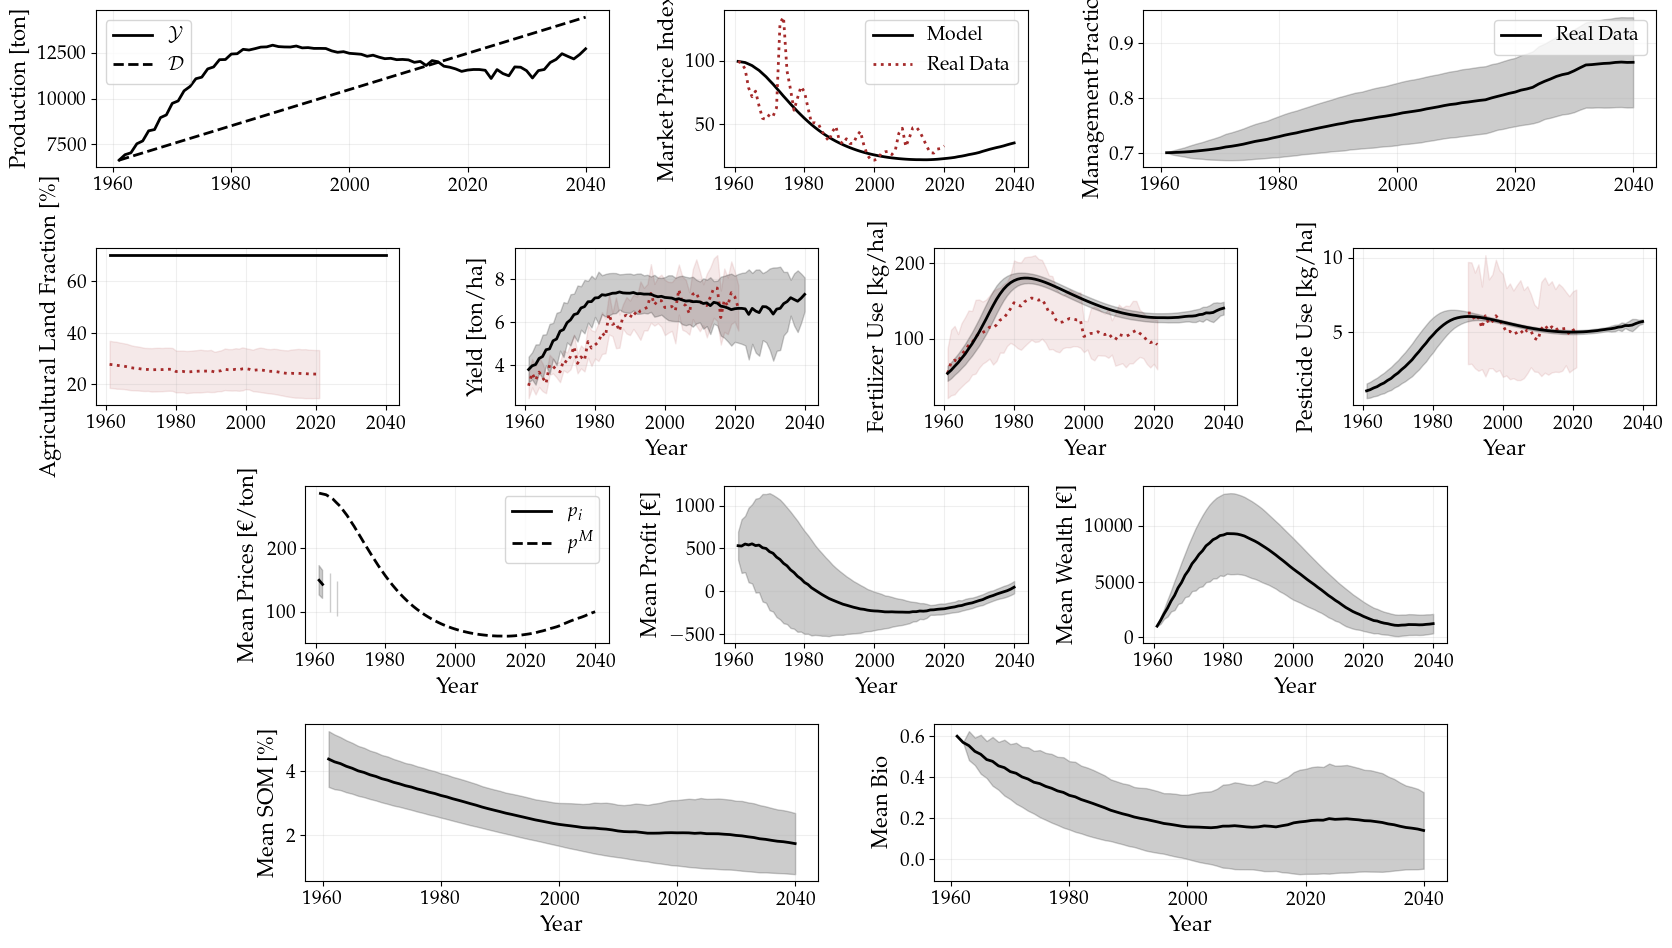

In [309]:
landscape.plot_data_comparison(df_list)

(array([151.,  30.,  14.,   8.,   5.,   4.,   0.,   1.,   0.,   1.]),
 array([ 1. ,  3.2,  5.4,  7.6,  9.8, 12. , 14.2, 16.4, 18.6, 20.8, 23. ]),
 <BarContainer object of 10 artists>)

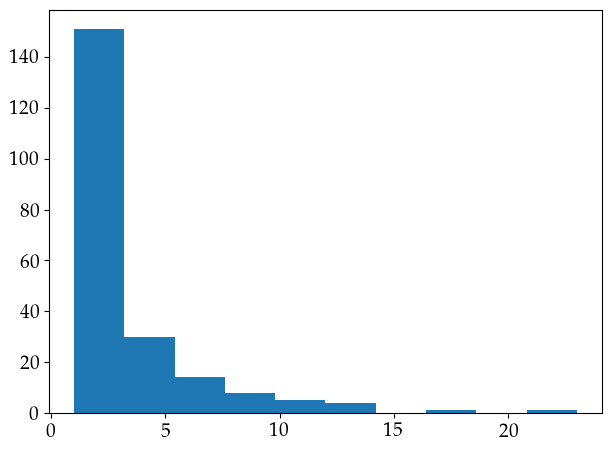

In [307]:
A, B = np.unique(landscape.farms_ownership, return_counts = True)
plt.hist(B[1:])

In [159]:
A = np.zeros((10,10), dtype = bool)
A[5,2] = True

B = np.random.rand(10,10)

indices = np.argwhere(A)

# Sort the indices based on the values in B
sorted_indices = indices[np.argsort(B[indices[:, 0], indices[:, 1]])[::-1]]
print(B[A])

print(sorted_indices)

[0.3889945]
[[5 2]]


In [160]:
for i, j in sorted_indices:
    A = np.zeros((10,10), dtype = bool)
    A[i,j] = True
    kernel = np.array([[1, 1, 1],
                    [1, 0, 1],
                    [1, 1, 1]]) 
    mask = convolve(A, kernel, mode='wrap').astype(bool)
    farmer_idx_candidates = np.argwhere(np.tensordot(mask, landscape.ownership) > 0 )
    print(farmer_idx_candidates)
    idx_winner = farmer_idx_candidates[np.argmax(landscape.wealth_per_farmer[farmer_idx_candidates])]
    print(idx_winner)
    



ValueError: shape-mismatch for sum

In [ ]:
A, A_ = np.unique(landscape.farms_ownership[landscape.land_type == 'C'], return_counts=True)
B, B_ = np.unique(landscape.ManagementPractices[landscape.land_type == 'C'], return_counts=True)

In [ ]:
A.size

25

In [ ]:
B.size

28

In [ ]:
kernel = np.array([[1, 1, 1],
                    [1, 0, 1],
                    [1, 1, 1]]) / 8.0
avg_neighbors = convolve((landscape.land_type != 'N').astype(float), kernel, mode='wrap')
print(avg_neighbors)

[[0.25  0.375 0.125 0.25  0.    0.25  0.25  0.25  0.375 0.625 0.625 0.5
  0.375 0.125 0.375 0.375 0.25  0.375 0.25  0.375 0.25  0.375 0.125 0.25
  0.375 0.625 0.375 0.25  0.125 0.25 ]
 [0.25  0.375 0.125 0.375 0.375 0.5   0.25  0.375 0.5   0.5   0.5   0.25
  0.25  0.25  0.25  0.375 0.125 0.375 0.25  0.375 0.375 0.25  0.25  0.125
  0.25  0.25  0.25  0.375 0.125 0.375]
 [0.    0.125 0.    0.125 0.125 0.375 0.5   0.375 0.25  0.25  0.375 0.25
  0.125 0.125 0.125 0.375 0.375 0.375 0.25  0.25  0.25  0.    0.25  0.
  0.25  0.25  0.25  0.375 0.125 0.375]
 [0.25  0.25  0.125 0.25  0.375 0.5   0.375 0.125 0.25  0.125 0.125 0.
  0.125 0.25  0.375 0.125 0.25  0.125 0.5   0.25  0.5   0.25  0.375 0.125
  0.125 0.    0.125 0.375 0.375 0.5  ]
 [0.375 0.25  0.    0.125 0.25  0.375 0.625 0.375 0.375 0.125 0.25  0.
  0.125 0.    0.25  0.25  0.5   0.375 0.5   0.125 0.375 0.125 0.25  0.125
  0.    0.    0.125 0.25  0.625 0.5  ]
 [0.375 0.375 0.125 0.125 0.25  0.375 0.375 0.25  0.375 0.375 0.5   0.125
  0.1

In [ ]:
avg_neighbors = avg_neighbors * (landscape.land_type == 'N')
print(avg_neighbors)
print(np.sum(avg_neighbors>0))

[[0.    0.375 0.    0.25  0.    0.25  0.25  0.    0.    0.    0.    0.5
  0.375 0.    0.375 0.375 0.    0.375 0.25  0.    0.    0.375 0.125 0.25
  0.375 0.625 0.    0.25  0.125 0.25 ]
 [0.25  0.375 0.125 0.375 0.375 0.5   0.    0.375 0.5   0.    0.    0.
  0.25  0.25  0.25  0.375 0.    0.375 0.25  0.375 0.375 0.25  0.25  0.125
  0.25  0.    0.    0.375 0.125 0.375]
 [0.    0.125 0.    0.125 0.    0.    0.5   0.375 0.25  0.25  0.375 0.25
  0.125 0.125 0.    0.375 0.375 0.375 0.    0.25  0.25  0.    0.25  0.
  0.25  0.25  0.25  0.375 0.    0.375]
 [0.25  0.25  0.125 0.25  0.375 0.5   0.    0.    0.25  0.125 0.125 0.
  0.125 0.25  0.375 0.    0.25  0.    0.5   0.    0.5   0.25  0.375 0.125
  0.125 0.    0.125 0.375 0.    0.5  ]
 [0.375 0.25  0.    0.125 0.25  0.    0.625 0.375 0.375 0.    0.25  0.
  0.125 0.    0.25  0.25  0.5   0.375 0.5   0.    0.375 0.    0.25  0.125
  0.    0.    0.125 0.    0.625 0.   ]
 [0.    0.375 0.125 0.125 0.25  0.    0.    0.25  0.375 0.    0.5   0.125
  0.125

In [ ]:
idx = np.random.choice(avg_neighbors.flatten().size, 10, p=avg_neighbors.flatten()/np.sum(avg_neighbors))

print(idx)
eligible_plots = np.zeros((landscape.size,landscape.size),dtype=bool)
eligible_plots.ravel()[idx] = True

print(np.sum(eligible_plots * (landscape.land_type == 'N')))

[842 327 870 818 550 512 343  18 110 665]
10


In [ ]:
self.eligible_plots = np.zeros((self.size,self.size),dtype=bool)
self.eligible_plots = np.reshape()

In [ ]:
B[1:].shape

(223,)

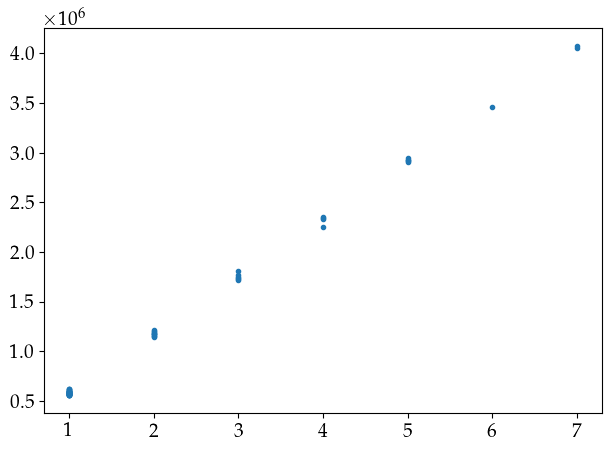

In [ ]:
plt.plot(B[1:], landscape.wealth_per_farmer, ls='', marker = 'o')